In [2]:
#https://rstudio-pubs-static.s3.amazonaws.com/100626_ec85ebc7451b42ae9e6d943691e3999b.html#:~:text=Global%20active%20power%20is%20the%20real%20power%20consumption%20i.e.%20the,is%20basically%20called%20wattfull%20power.
# Data Link: https://data.world/uci/individual-household-electric-power-consumption
# Attribute Information
#1.date: Date in format dd/mm/yyyy
# 2.time: time in format hh:mm:ss
# 3.global_active_power: household global minute-averaged active power (in kilowatt)
# 4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)
# 5.voltage: minute-averaged voltage (in volt)
# 6.global_intensity: household global minute-averaged current intensity (in ampere)
# 7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
# 8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
# 9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.
#'Solar Energy' = 'sun_radiation'*'peak_power_kwp'*'efficiency_factor'*'solar_panel_area'*30 (Per month)



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv('house_new.csv')
print(df.head())

   Date  Column1  Column2        Time  Global_active_power  \
0    16       12     2006  5:24:00 PM                4.216   
1    16       12     2006  5:25:00 PM                5.360   
2    16       12     2006  5:26:00 PM                5.374   
3    16       12     2006  5:27:00 PM                5.388   
4    16       12     2006  5:28:00 PM                3.666   

   Global_reactive_power  Voltage  Global_intensity  Sub_metering_1  \
0                  0.418   234.84              18.4             0.0   
1                  0.436   233.63              23.0             0.0   
2                  0.498   233.29              23.0             0.0   
3                  0.502   233.74              23.0             0.0   
4                  0.528   235.68              15.8             0.0   

   Sub_metering_2  Sub_metering_3  
0             1.0            17.0  
1             1.0            16.0  
2             2.0            17.0  
3             1.0            17.0  
4             1.0   

In [3]:
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'], format='%d %I:%M:%S %p')

#print(df['DateTime'])

In [4]:
df = df.rename(columns={'Date':'date', 'Column1': 'month', 'Column2': 'year'})

In [ ]:
#hourly prediction (mape is high)
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming df is your DataFrame with a datetime index named 'DateTime'

# Train-test split
train = df.iloc[:-24*7]  # Use all but the last 7 days for training
test = df.iloc[-24*7:]   # Use the last 7 days for testing

# Model training (example using SARIMA)
# You can replace this with any other time series model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['Global_active_power'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
results = model.fit()

# Forecasting
forecast = results.get_forecast(steps=24*7)  # Forecast for the next 7 days per hour
print(forecast)
# Evaluation
y_true = test['Global_active_power']
y_pred = forecast.predicted_mean

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print("MAPE:", mape)
print("MSE:", mse)
print("MAE:", mae)

# Optionally, you can visualize the forecasts and actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Global_active_power'], label='Train')
plt.plot(test.index, test['Global_active_power'], label='Test')
plt.plot(y_pred.index, y_pred, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.title('Power Consumption Forecast')
plt.legend()
plt.show()


In [5]:
df_new=df.drop(columns={'Time','DateTime'})
print(df_new)

         date  month  year  Global_active_power  Global_reactive_power  \
0          16     12  2006                4.216                  0.418   
1          16     12  2006                5.360                  0.436   
2          16     12  2006                5.374                  0.498   
3          16     12  2006                5.388                  0.502   
4          16     12  2006                3.666                  0.528   
...       ...    ...   ...                  ...                    ...   
1048570    13     12  2008                0.426                  0.076   
1048571    13     12  2008                0.424                  0.076   
1048572    13     12  2008                0.422                  0.076   
1048573    13     12  2008                0.422                  0.078   
1048574    13     12  2008                0.422                  0.078   

         Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  \
0         234.84              18.4       

In [6]:
summed_data = df_new.groupby(['date', 'month', 'year']).sum()
summed_data['Energy_consumption'] = summed_data['Sub_metering_1'] + summed_data['Sub_metering_2'] + summed_data['Sub_metering_3']
print(summed_data)

                 Global_active_power  Global_reactive_power    Voltage  \
date month year                                                          
1    1     2007             2749.004                148.166  345785.73   
           2008             2759.738                142.508  347092.81   
     2     2007             1824.760                150.264  346164.68   
           2008             1534.652                179.250  346118.79   
     3     2007              517.564                107.628  347502.82   
...                              ...                    ...        ...   
31   8     2008             1500.614                210.418  345385.38   
     10    2007             1283.210                107.200  346088.13   
           2008             1285.832                104.348  347514.87   
     12    2006             3494.196                150.852  345451.07   
           2007             2216.542                145.536  347176.50   

                 Global_intensity  Su

In [41]:
print(df[['month', 'year', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']])

         month  year  Global_reactive_power  Voltage  Global_intensity  \
0           12  2006                  0.418   234.84              18.4   
1           12  2006                  0.436   233.63              23.0   
2           12  2006                  0.498   233.29              23.0   
3           12  2006                  0.502   233.74              23.0   
4           12  2006                  0.528   235.68              15.8   
...        ...   ...                    ...      ...               ...   
1048570     12  2008                  0.076   242.27               1.8   
1048571     12  2008                  0.076   242.10               1.8   
1048572     12  2008                  0.076   241.73               1.8   
1048573     12  2008                  0.078   242.56               1.8   
1048574     12  2008                  0.078   242.61               1.8   

         Sub_metering_1  Sub_metering_2  Sub_metering_3  
0                   0.0             1.0            17

In [39]:
#not working (MAPE is high)
# Train-test split
X = df[['month', 'year', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
y = df['Global_active_power']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training (example using Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# Predict energy consumption
prediction = model.predict([[12, 2006, 34.922, 93552.53, 5180.8, 0.0, 546.0, 4926.0]])  # Using the provided single data point
print("Predicted energy consumption:", prediction[0])

# Predict energy consumption for all test samples
predictions = model.predict(X_test)

# Calculate MAPE and MSE
mape = mean_absolute_percentage_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print("MAPE:", mape)
print("MSE:", mse)

# Predict Sub_metering_1, Sub_metering_2, and Sub_metering_3 values along with Global_active_power
X_next_year = pd.DataFrame({
    'month': [1]*12 + [2]*12 + [3]*12 + [4]*12 + [5]*12 + [6]*12 + [7]*12 + [8]*12 + [9]*12 + [10]*12 + [11]*12 + [12]*12,
    'year': [2007]*12*12,
    'Global_reactive_power': [34.922]*12*12,
    'Voltage': [93552.53]*12*12,
    'Global_intensity': [5180.8]*12*12,
    'Sub_metering_1': [0.0]*12*12,
    'Sub_metering_2': [546.0]*12*12,
    'Sub_metering_3': [4926.0]*12*12
})

next_year_predictions = model.predict(X_next_year)
print("Predicted Global_active_power for next year:", next_year_predictions)



ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [14]:
summed_data = summed_data.reset_index()

# Filter the DataFrame for date=16, month=12, and year=2006
filtered_data = summed_data[(summed_data['date'] == 16) & (summed_data['month'] == 12) & (summed_data['year'] == 2006)]

# Print the filtered DataFrame
print(filtered_data)
print(summed_data.columns)

     index  date  month  year  Global_active_power  Global_reactive_power  \
380    380    16     12  2006             1209.176                 34.922   

      Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  \
380  93552.53            5180.8             0.0           546.0   

     Sub_metering_3  Energy_consumption  
380          4926.0              5472.0  
Index(['index', 'date', 'month', 'year', 'Global_active_power',
       'Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
       'Energy_consumption'],
      dtype='object')


C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Predicted energy consumption: 1222.4672610037542
MAPE: 0.9313528479452255
MSE: 297.46046774091826
Predicted Global_active_power for next year (Average of each month):
[1224.43883065 1224.94066898 1225.44250731 1225.94434565 1226.44618398
 1226.94802231 1227.44986065 1227.95169898 1228.45353732 1228.95537565
 1229.45721398 1229.95905232]


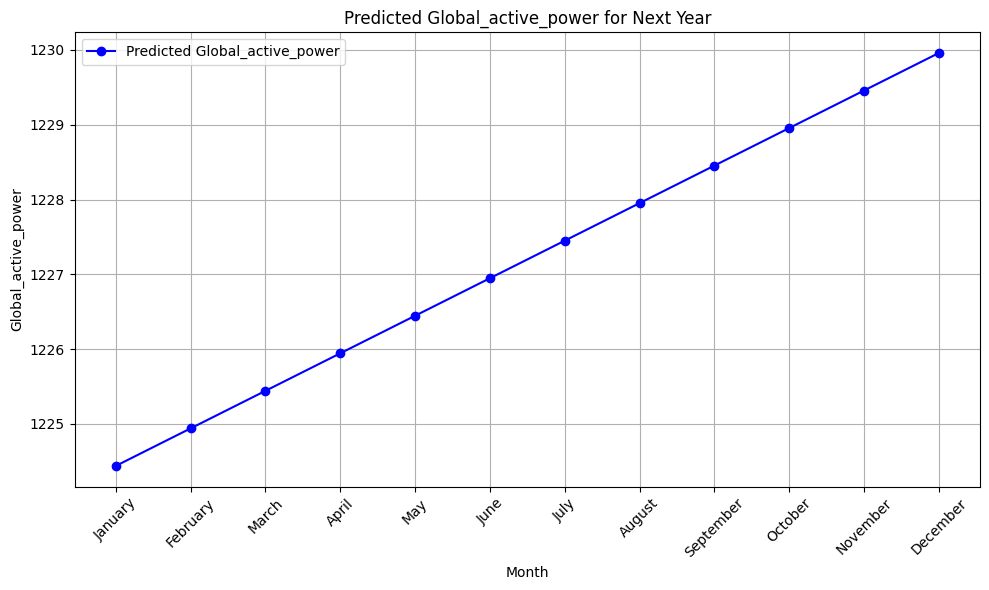

In [45]:
# Train-test split
X = summed_data[['month', 'year', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
y = summed_data['Global_active_power']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training (example using Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# Predict energy consumption
prediction = model.predict([[12, 2006, 34.922, 93552.53, 5180.8, 0.0, 546.0, 4926.0]])  # Using the provided single data point
print("Predicted energy consumption:", prediction[0])

# Predict energy consumption for all test samples
predictions = model.predict(X_test)

# Calculate MAPE and MSE
mape = mean_absolute_percentage_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print("MAPE:", mape)
print("MSE:", mse)

# Predict Sub_metering_1, Sub_metering_2, and Sub_metering_3 values along with Global_active_power
X_next_year = pd.DataFrame({
    'month': [1]*12 + [2]*12 + [3]*12 + [4]*12 + [5]*12 + [6]*12 + [7]*12 + [8]*12 + [9]*12 + [10]*12 + [11]*12 + [12]*12,
    'year': [2007]*12*12,
    'Global_reactive_power': [34.922]*12*12,
    'Voltage': [93552.53]*12*12,
    'Global_intensity': [5180.8]*12*12,
    'Sub_metering_1': [0.0]*12*12,
    'Sub_metering_2': [546.0]*12*12,
    'Sub_metering_3': [4926.0]*12*12
})

next_year_predictions = model.predict(X_next_year)
import pandas as pd

# Assuming X_next_year is defined as per your code

# Predict Global_active_power for next year
next_year_predictions = model.predict(X_next_year)

# Reshape the predictions to have 12 rows (one for each month)
next_year_predictions_reshaped = next_year_predictions.reshape(12, -1)

# Take the average of predictions for each month
average_predictions_per_month = next_year_predictions_reshaped.mean(axis=1)

print("Predicted Global_active_power for next year (Average of each month):")
print(average_predictions_per_month)

# Months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(months, average_predictions_per_month, marker='o', color='b', label='Predicted Global_active_power')
plt.title('Predicted Global_active_power for Next Year')
plt.xlabel('Month')
plt.ylabel('Global_active_power')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
summed_data_by_month = summed_data.groupby(['month', 'year']).sum()
summed_data_by_month = summed_data_by_month.reset_index()
#print(summed_data_by_month)


In [34]:
summed_data_by_month['sun_radiation'] = [1.906451613,2.796774194,2.592857143,6.551612903,5.613333333,5.383870968,5.45,4.24516129,7.161290323,3.763333333,3.732258065,2.816666667,2.458064516,
    2.970967742,2.417857143,3.1,4.896666667,6.206451613,7.556666667,3.719354839,4.506451613,5.006666667,3.393548387,2.573333333,1.770967742]

#print(summed_data_by_month[['month','sun_radiation']])

summed_data_by_month['peak_power_kwp'] = [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3]
#print(summed_data_by_month['peak_power_kwp'])

summed_data_by_month['solar_panel_area'] = summed_data_by_month['peak_power_kwp']/0.2
#print(summed_data_by_month['solar_panel_area'])

summed_data_by_month['efficiency_factor'] = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
#print(summed_data_by_month[['peak_power_kwp','efficiency_factor']])

summed_data_by_month['Solar Energy'] = summed_data_by_month['sun_radiation']*summed_data_by_month['peak_power_kwp']*summed_data_by_month['efficiency_factor']*summed_data_by_month['solar_panel_area']*30
#print(summed_data_by_month['Solar Energy'])



In [102]:
# Filter the DataFrame for the year 2007
summed_data_2007 = summed_data_by_month[summed_data_by_month['year'] == 2007]

# Filter the DataFrame for the year 2008
summed_data_2008 = summed_data_by_month[summed_data_by_month['year'] == 2008]

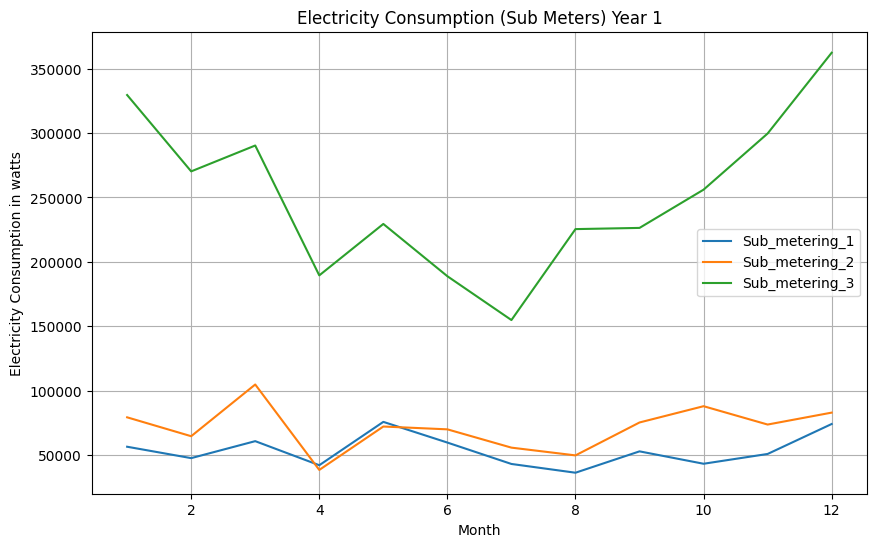

In [153]:


# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(summed_data_2007['month'], summed_data_2007['Sub_metering_1'], label='Sub_metering_1')
plt.plot(summed_data_2007['month'], summed_data_2007['Sub_metering_2'], label='Sub_metering_2')
plt.plot(summed_data_2007['month'], summed_data_2007['Sub_metering_3'], label='Sub_metering_3')
plt.xlabel('Month')
plt.ylabel('Electricity Consumption in watts')
plt.title('Electricity Consumption (Sub Meters) Year 1')
plt.legend()
plt.grid(True)
plt.show()


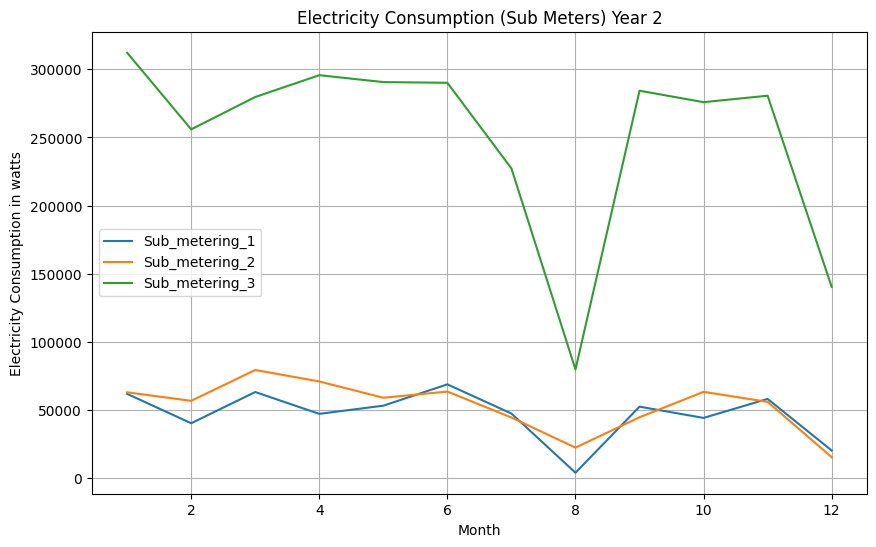

In [154]:
# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(summed_data_2008['month'], summed_data_2008['Sub_metering_1'], label='Sub_metering_1')
plt.plot(summed_data_2008['month'], summed_data_2008['Sub_metering_2'], label='Sub_metering_2')
plt.plot(summed_data_2008['month'], summed_data_2008['Sub_metering_3'], label='Sub_metering_3')
plt.xlabel('Month')
plt.ylabel('Electricity Consumption in watts')
plt.title('Electricity Consumption (Sub Meters) Year 2')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
print(summed_data_2007)

    month  year  index  date  Global_active_power  Global_reactive_power  \
0       1  2007  11123   496            69011.862               5922.396   
2       2  2007   9101   406            56488.886               4581.608   
4       3  2007  11242   496            58862.192               5122.184   
6       4  2007  10585   465            35181.466               4688.994   
8       5  2007  11364   496            44008.872               5148.894   
10      6  2007  10705   465            35682.828               6317.980   
12      7  2007  11486   496            29703.830               5674.062   
14      8  2007  11548   496            34096.460               5033.644   
16      9  2007  10885   465            41872.606               5443.416   
18     10  2007  11670   496            49276.370               4171.170   
20     11  2007  11005   465            55918.644               4170.904   
23     12  2007  11808   496            72604.170               4950.484   

        Vol

In [20]:
summed_data_by_month = summed_data_by_month.sort_values(by=['year', 'month'])
print(summed_data_by_month[['month','year']])

    month  year
22     12  2006
0       1  2007
2       2  2007
4       3  2007
6       4  2007
8       5  2007
10      6  2007
12      7  2007
14      8  2007
16      9  2007
18     10  2007
20     11  2007
23     12  2007
1       1  2008
3       2  2008
5       3  2008
7       4  2008
9       5  2008
11      6  2008
13      7  2008
15      8  2008
17      9  2008
19     10  2008
21     11  2008
24     12  2008


In [22]:
print(summed_data_by_month)

    month  year  index  date  Global_active_power  Global_reactive_power  \
22     12  2006   8943   376            41813.282               2889.436   
0       1  2007  11123   496            69011.862               5922.396   
2       2  2007   9101   406            56488.886               4581.608   
4       3  2007  11242   496            58862.192               5122.184   
6       4  2007  10585   465            35181.466               4688.994   
8       5  2007  11364   496            44008.872               5148.894   
10      6  2007  10705   465            35682.828               6317.980   
12      7  2007  11486   496            29703.830               5674.062   
14      8  2007  11548   496            34096.460               5033.644   
16      9  2007  10885   465            41872.606               5443.416   
18     10  2007  11670   496            49276.370               4171.170   
20     11  2007  11005   465            55918.644               4170.904   
23     12  2

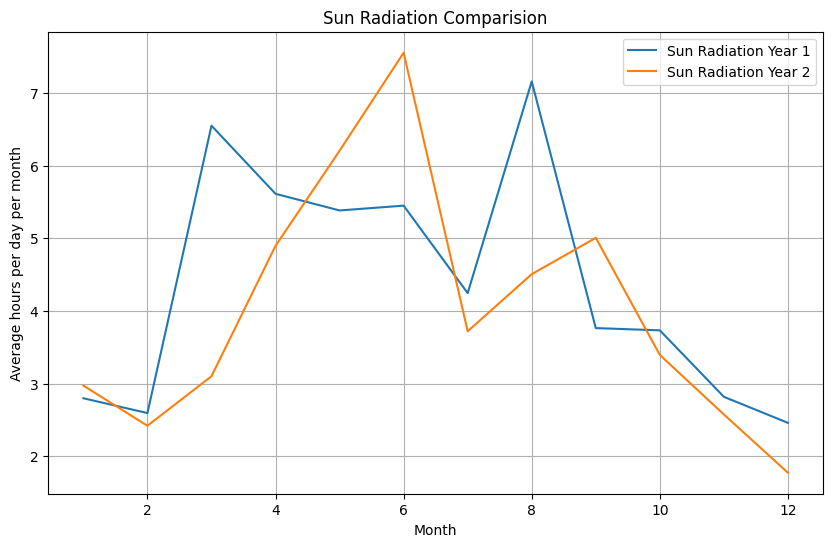

In [155]:
plt.figure(figsize=(10, 6))
plt.plot(summed_data_2007['month'], summed_data_2007['sun_radiation'], label='Sun Radiation Year 1')
plt.plot(summed_data_2008['month'], summed_data_2008['sun_radiation'], label='Sun Radiation Year 2')
plt.xlabel('Month')
plt.ylabel('Average hours per day per month')
plt.title('Sun Radiation Comparision')
plt.legend()
plt.grid(True)
plt.show()


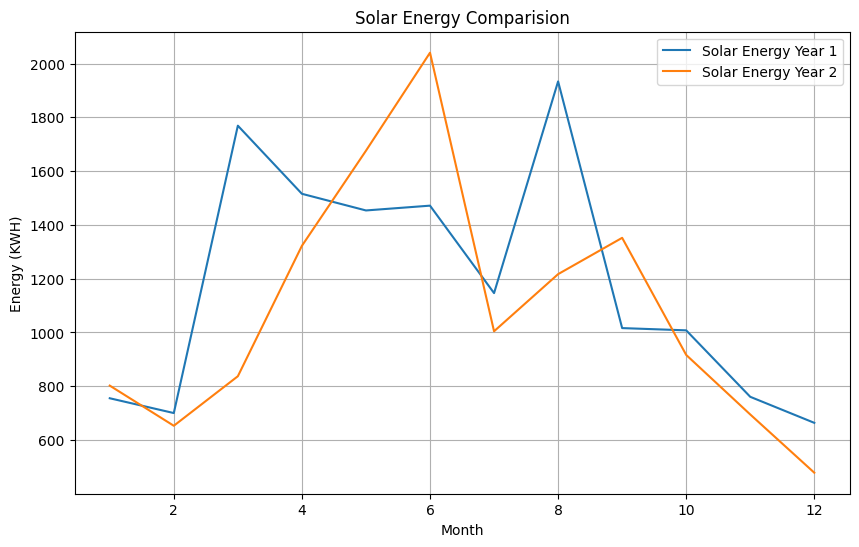

In [157]:
plt.figure(figsize=(10, 6))
plt.plot(summed_data_2007['month'], summed_data_2007['Solar Energy'], label='Solar Energy Year 1')
plt.plot(summed_data_2008['month'], summed_data_2008['Solar Energy'], label='Solar Energy Year 2')
plt.xlabel('Month')
plt.ylabel('Energy (KWH)')
plt.title('Solar Energy Comparision')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
print(summed_data_by_month)

    month  year  index  date  Global_active_power  Global_reactive_power  \
22     12  2006   8943   376            41813.282               2889.436   
0       1  2007  11123   496            69011.862               5922.396   
2       2  2007   9101   406            56488.886               4581.608   
4       3  2007  11242   496            58862.192               5122.184   
6       4  2007  10585   465            35181.466               4688.994   
8       5  2007  11364   496            44008.872               5148.894   
10      6  2007  10705   465            35682.828               6317.980   
12      7  2007  11486   496            29703.830               5674.062   
14      8  2007  11548   496            34096.460               5033.644   
16      9  2007  10885   465            41872.606               5443.416   
18     10  2007  11670   496            49276.370               4171.170   
20     11  2007  11005   465            55918.644               4170.904   
23     12  2

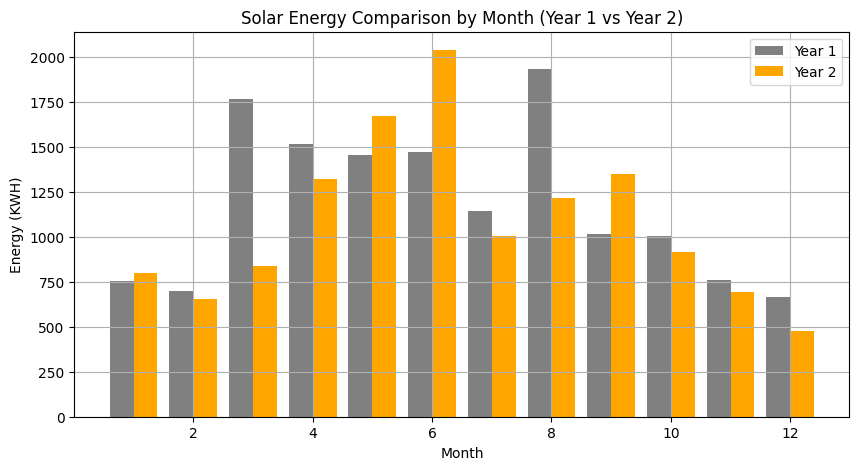

In [158]:
plt.figure(figsize=(10, 5))

# Define colors for each year
colors = ['grey', 'orange']

# Loop through each month (assuming all datasets have the same months)
for i, month in enumerate(range(1, 13)):
    # Get the solar energy generation for each year for the current month
    solar_energy_2007 = summed_data_2007[summed_data_2007['month'] == month]['Solar Energy'].values[0]
    solar_energy_2008 = summed_data_2008[summed_data_2008['month'] == month]['Solar Energy'].values[0]
    
    # Plot the bar chart for the current month
    plt.bar(month - 0.2, solar_energy_2007, width=0.4, label=f'Month {month} - 2007', align='center', color=colors[0])
    plt.bar(month + 0.2, solar_energy_2008, width=0.4, label=f'Month {month} - 2008', align='center', color=colors[1])

# Set x-axis labels
plt.xlabel('Month')
plt.ylabel('Energy (KWH)')

# Set plot title
plt.title('Solar Energy Comparison by Month (Year 1 vs Year 2)')

# Add legend
plt.legend(['Year 1', 'Year 2'])

# Show grid
plt.grid(True)

# Show the plot
plt.show()


    Sub_metering_1_pred  Sub_metering_2_pred  Sub_metering_3_pred  \
0               61761.0              62911.0             312175.0   
1               40192.0              56646.0             255918.0   
2               63110.0              79277.0             279670.0   
3               47080.0              70871.0             295678.0   
4               53084.0              58907.0             290620.0   
5               68728.0              63449.0             290103.0   
6               47313.0              44416.0             227228.0   
7                3873.0              22264.0              79665.0   
8               52376.0              44590.0             284282.0   
9               44093.0              63228.0             275887.0   
10              58067.0              55887.0             280615.0   
11              20170.0              15313.0             140296.0   

    Global_active_power_pred  Energy_consumption_pred  
0                  65169.382                 4

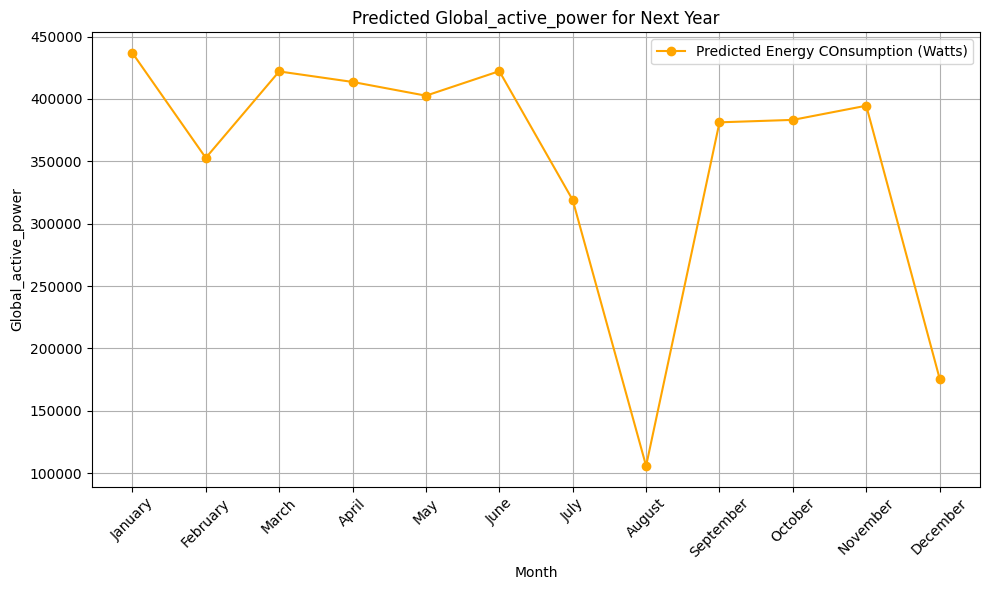

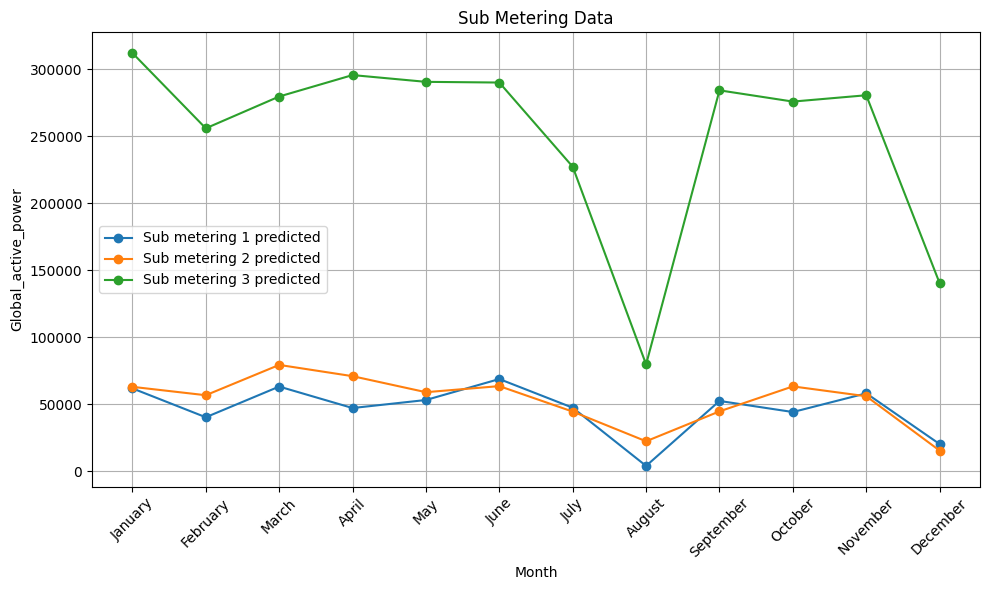

In [73]:
#working model House Energy COnsumption and Global Active Power Prediction

# Select relevant columns and set datetime index if necessary
selected_columns = ['month', 'year', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Energy_consumption', 'Global_active_power']
data = summed_data_by_month[selected_columns]

# Train-test split
X = data[['month','Global_active_power','Global_intensity','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
y = data[[ 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','Global_active_power','Energy_consumption']]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X[:-12]
y_train = y[:-12]
X_test = X[-12:]
y_test = y[-12:]

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Predict energy consumption for the next 12 months
predictions = model.predict(X_test)

# Output predictions for the next 12 months
output = pd.DataFrame({
    'Sub_metering_1_pred': predictions[:, 0],
    'Sub_metering_2_pred': predictions[:, 1],
    'Sub_metering_3_pred': predictions[:, 2],
    'Global_active_power_pred': predictions[:, 3],
    'Energy_consumption_pred': predictions[:, 4]
})
print(output)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
# Calculate MAPE, MAE, and MSE
mape = mean_absolute_percentage_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print("MAPE:", mape)
print("MAE:", mae)
print("MSE:", mse)

# Months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot
plt.figure(figsize=(10, 6))
#plt.plot(months, output['Global_active_power_pred'], marker='o', color='b', label='Predicted Global_active_power (KWH)')
plt.plot(months, output['Energy_consumption_pred'], marker='o', color='orange', label='Predicted Energy COnsumption (Watts)')
plt.title('Predicted Global_active_power for Next Year')
plt.xlabel('Month')
plt.ylabel('Global_active_power')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(months, output['Sub_metering_1_pred'], marker='o', label='Sub metering 1 predicted')
plt.plot(months, output['Sub_metering_2_pred'], marker='o', label='Sub metering 2 predicted')
plt.plot(months, output['Sub_metering_3_pred'], marker='o', label='Sub metering 3 predicted')
plt.title('Sub Metering Data')
plt.xlabel('Month')
plt.ylabel('Global_active_power')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [89]:
#solar panels energy production prediction
sv_panels = summed_data_by_month[['month','year','sun_radiation','peak_power_kwp','solar_panel_area', 'efficiency_factor', 'Solar Energy']]
#print(sv_panels.loc[sv_panels['year'] == 2007, 'Solar Energy'].sum())


In [96]:
summed_data_by_month['with SV'] = summed_data_by_month['Energy_consumption']/1000-summed_data_by_month['Solar Energy']
summed_data_by_month['Total House'] = summed_data_by_month['Global_active_power']-summed_data_by_month['Energy_consumption']/1000
print(summed_data_by_month[['month','year','Global_active_power','Energy_consumption','Solar Energy','with SV','Total House']])

    month  year  Global_active_power  Energy_consumption  Solar Energy  \
22     12  2006            41813.282            239123.0    514.741936   
0       1  2007            69011.862            465285.0    755.129032   
2       2  2007            56488.886            382462.0    700.071429   
4       3  2007            58862.192            455892.0   1768.935484   
6       4  2007            35181.466            269998.0   1515.600000   
8       5  2007            44008.872            377317.0   1453.645161   
10      6  2007            35682.828            318462.0   1471.500000   
12      7  2007            29703.830            253600.0   1146.193548   
14      8  2007            34096.460            311404.0   1933.548387   
16      9  2007            41872.606            354493.0   1016.100000   
18     10  2007            49276.370            387212.0   1007.709678   
20     11  2007            55918.644            424179.0    760.500000   
23     12  2007            72604.170  

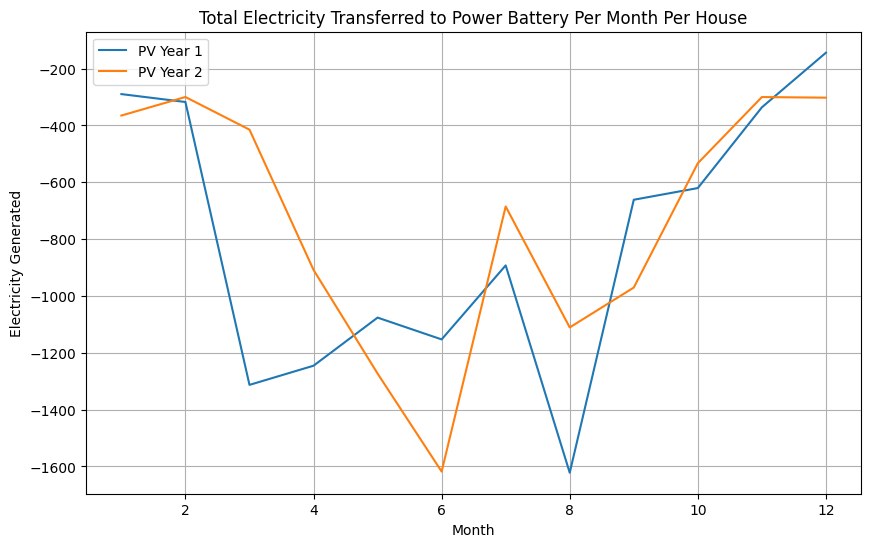

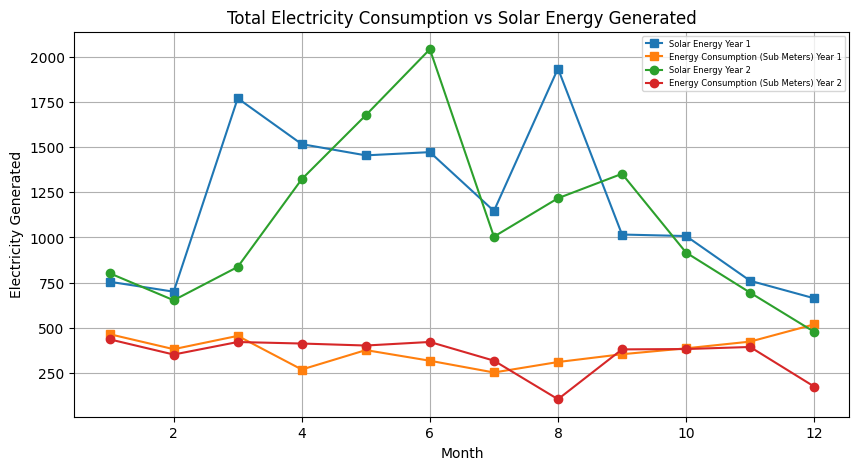

In [159]:


# Plot the graph Solar panels Energy Generation
plt.figure(figsize=(10, 6))
plt.plot(summed_data_2007['month'], summed_data_2007['with SV'], label='PV Year 1')
plt.plot(summed_data_2008['month'], summed_data_2008['with SV'], label='PV Year 2')
plt.xlabel('Month')
plt.ylabel('Electricity Generated')
plt.title('Total Electricity Transferred to Power Battery Per Month Per House')
plt.legend()
plt.grid(True)
plt.show()



# Plot the graph With SVs and without SVs (Included only Sub_meters)
plt.figure(figsize=(10, 5))
plt.plot(summed_data_2007['month'], summed_data_2007['Solar Energy'],label='Solar Energy Year 1', marker = 's')
plt.plot(summed_data_2007['month'], summed_data_2007['Energy_consumption']/1000, label='Energy Consumption (Sub Meters) Year 1',marker = 's')
plt.plot(summed_data_2008['month'], summed_data_2008['Solar Energy'], label='Solar Energy Year 2',marker = 'o')
plt.plot(summed_data_2008['month'], summed_data_2008['Energy_consumption']/1000, label='Energy Consumption (Sub Meters) Year 2',marker = 'o')
plt.xlabel('Month')
plt.ylabel('Electricity Generated')
plt.title('Total Electricity Consumption vs Solar Energy Generated')
plt.legend(fontsize=6)
plt.grid(True)
plt.show()


In [144]:
# Train-test split
X = summed_data_by_month[['month','year', 'sun_radiation', 'peak_power_kwp', 'solar_panel_area', 'efficiency_factor']]
y = summed_data_by_month[['Solar Energy']]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X[:-12]
y_train = y[:-12]
X_test = X[-12:]
y_test = y[-12:]

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Predict energy consumption for the next 12 months
predictions = model.predict(X_test)

# Output predictions for the next 12 months
output = pd.DataFrame({
    'Solar Energy': predictions[:, 0]
})
print(output)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
# Calculate MAPE, MAE, and MSE
mape = mean_absolute_percentage_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print("MAPE:", mape)
print("MAE:", mae)
print("MSE:", mse)


    Solar Energy
0     802.161290
1     652.821429
2     837.000000
3    1322.100000
4    1675.741936
5    2040.300000
6    1004.225807
7    1216.741936
8    1351.800000
9     916.258064
10    694.800000
11    478.161290
MAPE: 8.984598363650507e-14
MAE: 8.289665250534503e-13
MSE: 6.96048790185409e-25


In [149]:
print(summed_data_by_month.columns)
print(summed_data_by_month[['month','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
       'Energy_consumption']])

Index(['month', 'year', 'index', 'date', 'Global_active_power',
       'Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
       'Energy_consumption', 'sun_radiation', 'peak_power_kwp',
       'solar_panel_area', 'efficiency_factor', 'Solar Energy', 'with SV',
       'Total House'],
      dtype='object')
    month  Sub_metering_1  Sub_metering_2  Sub_metering_3  Energy_consumption
22     12         27460.0         48712.0        162951.0            239123.0
0       1         56433.0         79274.0        329578.0            465285.0
2       2         47584.0         64604.0        270274.0            382462.0
4       3         60769.0        104762.0        290361.0            455892.0
6       4         42078.0         38417.0        189503.0            269998.0
8       5         75737.0         72132.0        229448.0            377317.0
10      6         59672.0         69939.0        188851.0            318462.0
12  